In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import cross_val_score

import pandas as pd
import numpy as np
import re

### Define Metrics

In [2]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

### This method creates classification integer
Positive tweets : 1
Neutral tweets : 0
Negative tweets : -1

In [3]:
#New column for classification labels, either 1 or 0
def scoreCol(df, text_field):
    scores = []
    for x in df[text_field]:
        if x == 'positive':
            x = 2
            scores.append(x)
        elif x == 'negative':
            x = 0
            scores.append(x)
        elif x == 'neutral':
            x = 1
            scores.append(x)
    df['scores'] = scores
    return df

### Read in dataset
The first dataset is going to be the cleaned dataset

In [4]:
#Read data into dataframe
data = pd.read_csv(r'cleanedData.csv')

In [5]:
#Call classification label method
data = scoreCol(data,'sentiment')

Get list of Tokens for each tweet

In [6]:
listOfTokens = []
for tokensUnparsed in data["text"].tolist():
    tokensUnparsed = re.sub("(\\'|'|\\\")", '"', tokensUnparsed)
    listOfTokens.append(tokensUnparsed[2:-2].split('", "'))
print(listOfTokens[:5])

[['would', 'respond', 'go'], ['sooo', 'sad', 'miss', 'san', 'diego'], ['boss', 'bully'], ['interview', 'leave', 'alone'], ['son', 'could', 'not', 'put', 'release', 'already', 'buy']]


Do a check so see the corpus size and the size of the vocabulary:

In [7]:
all_words = [token for tokens in listOfTokens for token in tokens]
sentence_lengths = [len(tokens) for tokens in listOfTokens]
Vocabulary = sorted(list(set(all_words)))
print("%s tokens total, with a vocabulary size of %s" % (len(all_words), len(Vocabulary)))

198400 tokens total, with a vocabulary size of 23263


Create the list_corpus and the labels:

In [8]:
# Create list_corpus
token_list = data['text'].tolist()
list_corpus = []
for tokens in token_list:
    tokens = tokens.replace("[","").replace("]","").replace("'","").replace(",","")
    list_corpus.append(tokens)
print(list_corpus[:5])

# Get labels
list_labels = []
for l in data['scores'].tolist():
    label = int(l)
    list_labels.append(label)

['would respond go', 'sooo sad miss san diego', 'boss bully', 'interview leave alone', 'son could not put release already buy']


In [9]:
#Do a check...
print(list_corpus[:5])
print(list_labels[:5])

['would respond go', 'sooo sad miss san diego', 'boss bully', 'interview leave alone', 'son could not put release already buy']
[1, 0, 0, 0, 0]


### Create TF-IDF Vectorizer 

In [10]:
# Convert all review documents to a sparse matrix of token counts
vectorizer = TfidfVectorizer() 
termDocumentMatrix = vectorizer.fit_transform(list_corpus)

In [11]:
#Split the training dataset into two sections:
x_train, x_test, y_train, y_test = train_test_split(termDocumentMatrix, list_labels, test_size = 0.2)

In [12]:
#Create a Multinominal Classifier
mnb = MultinomialNB()

In [13]:
#Train the model using the training sets
mnb.fit(x_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [14]:
#Predict the response for test dataset
y_predicted_counts = mnb.predict(x_test)

In [15]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)

data = cleaned Dataset: vectorizer = TfidfVectorizer, accuracy = 0.614, precision = 0.665, recall = 0.614, f1 = 0.605
data = cleaned Dataset: vectorizer = CountVectorizer, accuracy = 0.614, precision = 0.665, recall = 0.614, f1 = 0.605


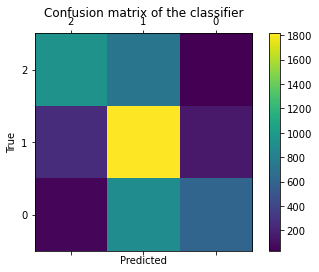

[[ 940  724   31]
 [ 255 1817  152]
 [  64  897  617]]


In [16]:
print("data = cleaned Dataset: vectorizer = TfidfVectorizer, accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
import pylab as pl
import matplotlib.pyplot as plt
print("data = cleaned Dataset: vectorizer = CountVectorizer, accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
labels = [2,1,0]
cm = metrics.confusion_matrix(y_test,y_predicted_counts, labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(cm)

### Cross fold validation 

In [17]:
print(len(vectorizer.get_feature_names()))

23241


In [18]:
print(termDocumentMatrix.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [19]:
real_pred = pd.DataFrame({'y_true':y_test, 'y_pred':y_predicted_counts})
real_pred

,y_true,y_pred
0,2,1
1,2,2
2,0,1
3,2,2
4,1,1
...,...,...
5492,2,1
5493,2,2
5494,1,1
5495,1,1


In [20]:
cv_results = cross_val_score(mnb, x_train, y_train, scoring = 'accuracy', cv=5, n_jobs=-1)

In [21]:
cv_results

array([0.62383443, 0.61382761, 0.61450989, 0.62201501, 0.61101001])

In [22]:
print("Accuracy archived: {0} %".format( round(accuracy_score(real_pred['y_true'],real_pred['y_pred']), 2)))

Accuracy archived: 0.61 %


In [23]:
print(classification_report(real_pred['y_true'],real_pred['y_pred']))

              precision    recall  f1-score   support

           0       0.77      0.39      0.52      1578
           1       0.53      0.82      0.64      2224
           2       0.75      0.55      0.64      1695

    accuracy                           0.61      5497
   macro avg       0.68      0.59      0.60      5497
weighted avg       0.67      0.61      0.60      5497

